# DIverse Counterfactual Explanations (DICE)

In this tutorial, you will learn how to implement a specific type of post-hoc explanations: counterfactual explanations. But what do counterfactual explanations mean?. This kind of explanations is intended to show how the model works by creating hypothetical examples  with a prediction with respect to the initial studied instance. In order to do so, we are going to focus on the application of DiCE(original article: Mothilal et al.[[1](https://arxiv.org/pdf/1905.07697.pdf)]) using the framework developped by Mothilal, Sharma and Tan https://github.com/interpretml/DiCE.



## How DiCE generate counterfactual explanations?

The main idea is to generate a set of k counterfactual examples $\{c_1, c_2, ..., c_k\}$ such the decision of the model $f$ given an instance $x$ changes. However, we have to take into account that generating counterfactual examples with a high number of features that have changed is not the ideal approach (Diversity). In the other hand we need to consider counterfactual examples that are close to the original instance $x$ (Proximity) otherwise the explanations will not be useful.

Diversity via Determinantal Point Process:

\begin{gather}
dpp\_diversity  = det(K)
\end{gather}
where $K_{i,j} = \frac{1}{1+dist(c_i,c_j)} $ and $dist(c_i,c_j)$ is a distanc metric.

Proximity:
\begin{gather}
Proximity  := -\frac{1}{k} \sum_{i=1}^{k} dist(c_i, x)
\end{gather}

Beyond these main constraints, DiCE allows us to implement constraints that are related to "real world" problems (e.g., an upper bound for some variables)


Based on these definitions DiCE considers the next loss function to be optimized.

\begin{gather}
C(x)  = arg\;min_{c_1, c_2, ..., c_k} \frac{1}{k}\sum_{i=1}^{k} yloss(f(c_i), y) + \frac{\lambda_1}{k} \sum_{i=1}^{k} dist(c_i, x) \\ - \lambda_2 dpp\_diversity(c_1, c_2, ..., c_k)
\end{gather}

where $yloss()$ is a function that measures the distance between $f(c_i)$ and the desired outcome $y$. Both $\lambda_1$ and $\lambda_2$ are hyperparameters that balance the three parts of the loss function.

## Use Case: Breast cancer Prediction

## 📥 **Importation des Bibliothèques**
Nous allons importer toutes les bibliothèques nécessaires pour le projet.


In [1]:
# 📥 Importation des bibliothèques
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import warnings
import seaborn as sns


# Réglages
shap.initjs()
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
plt.rc("font", size=16)

# 📊 Chargement et Préparation des Données

Nous allons utiliser le dataset breast cancer pour simuler un modèle de prédiction du **cancer du sein**.  


## 🛠 **Préparation**

In [3]:
# 📥 Chargement des données
selected_features = [
    'mean concave points',
    'area error',
    'worst area',
    'worst concave points',
    'worst texture',
    'worst perimeter',
    'worst concavity',
    'mean texture',
    'mean area'
]
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)[selected_features]  # Convertir en DataFrame
y = pd.Series(data.target, name="target")  # Convertir en Série
y = y.map({0: 1, 1: 0})  # Inverser pour garder la convention label(1)=cancer

# 🔀 Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=80)

# 📊 Affichage de la distribution initiale des classes
print("📌 Distribution des classes :")
print(pd.Series(y).value_counts())

# 🔍 Aperçu des données
print("\n🔍 Aperçu des premières lignes du dataset :")
print(X.head())

📌 Distribution des classes :
target
0    357
1    212
Name: count, dtype: int64

🔍 Aperçu des premières lignes du dataset :
   mean concave points  area error  worst area  worst concave points  \
0              0.14710      153.40      2019.0                0.2654   
1              0.07017       74.08      1956.0                0.1860   
2              0.12790       94.03      1709.0                0.2430   
3              0.10520       27.23       567.7                0.2575   
4              0.10430       94.44      1575.0                0.1625   

   worst texture  worst perimeter  worst concavity  mean texture  mean area  
0          17.33           184.60           0.7119         10.38     1001.0  
1          23.41           158.80           0.2416         17.77     1326.0  
2          25.53           152.50           0.4504         21.25     1203.0  
3          26.50            98.87           0.6869         20.38      386.1  
4          16.67           152.20           0.4000   

In [ ]:
# 🚀 Entraînement du Modèle Random forest

In [4]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    "n_estimators": 50,
    "max_depth": 8,
    "random_state":27,
}
rf = RandomForestClassifier(**params_rf)
model = rf.fit(X_train , y_train)

Apprécions les résultats de prédiction :

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

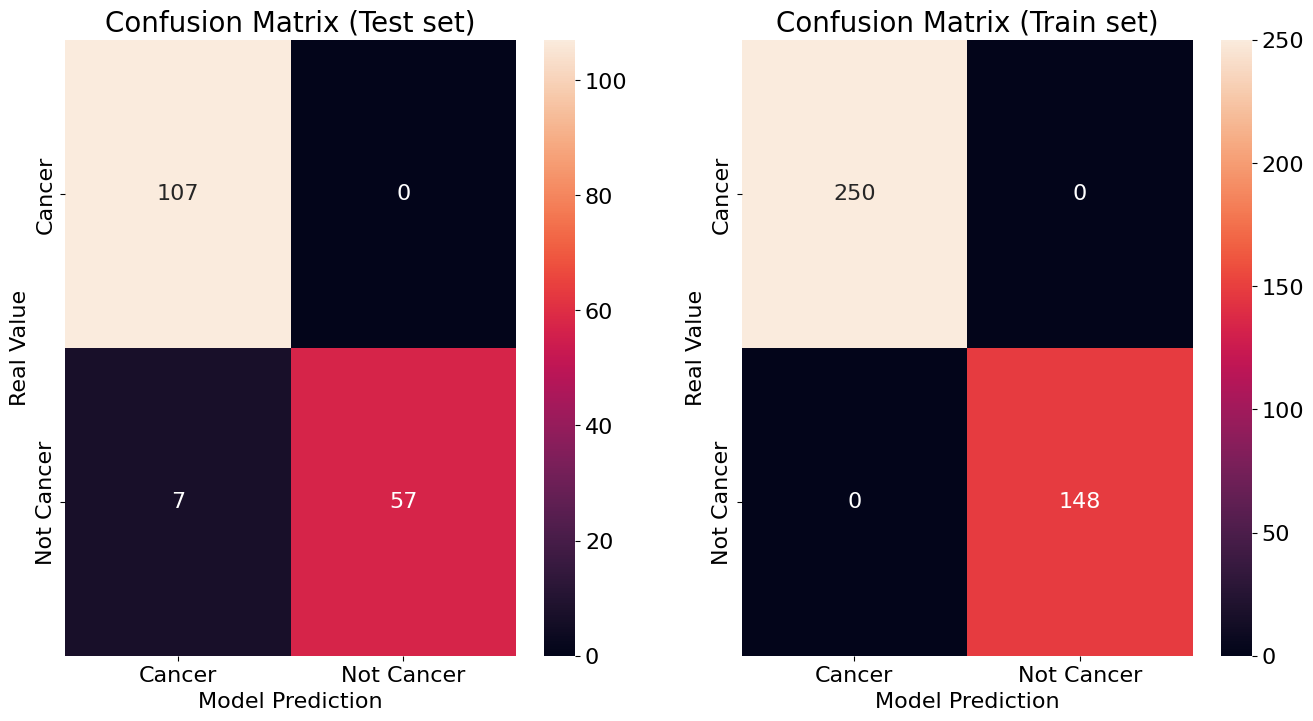

In [5]:
from sklearn import metrics

y_hat = rf.predict(X_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=rf.predict(X_train), y_true=y_train)
names_df = [
    "Cancer",
    "Not Cancer"
]
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

### DiCE

In [7]:
#Loading the dice module
! pip install dice-ml
import dice_ml
from dice_ml.utils import helpers
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 110.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.12.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.1 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [8]:
#DiCE data object
dataset = pd.concat([X, y], axis=1)
#{1.0: "Cancer", 0.0: "Not Cancer"}
data = dice_ml.Data(dataframe=dataset, continuous_features=X.columns.tolist(), outcome_name='target')
#DiCE model object
model_exp = dice_ml.Model(model=model, backend='sklearn')
#Creates the explanations
exp = dice_ml.Dice(data, model_exp, method="random")

Test avec une prédiction confiante:

In [24]:
#We take an example of our training set
#We set the number of counterfactual explanations to 2.
patient_index = 1
features_to_vary = [
    "worst perimeter",
    "worst area",
    "worst concavity",
    "worst concave points",
    "mean texture"

]
e1 = exp.generate_counterfactuals(X_test[patient_index:patient_index+1],
                                  total_CFs=10,
                                  desired_class="opposite",
                                 random_seed=80,
                                 features_to_vary=features_to_vary)
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

Query instance (original outcome : 1)


,mean concave points,area error,worst area,worst concave points,worst texture,worst perimeter,worst concavity,mean texture,mean area,target
0,0.08465,224.100006,3143.0,0.182,26.440001,199.5,0.2861,17.25,1546.0,1



Diverse Counterfactual set (new outcome: 0)


,mean concave points,area error,worst area,worst concave points,worst texture,worst perimeter,worst concavity,mean texture,mean area,target
0,0.08465,224.1,3143.0,0.0,26.44,199.5,0.0,10.46,1546.0,0
1,0.08465,224.1,3143.0,0.0,26.44,199.5,0.1,11.60,1546.0,0
2,0.08465,224.1,3143.0,0.0,26.44,76.1,0.2,17.25,1546.0,0
3,0.08465,224.1,3143.0,0.0,26.44,199.5,0.1,11.33,1546.0,0
4,0.08465,224.1,3143.0,0.0,26.44,51.9,0.0,17.25,1546.0,0
5,0.08465,224.1,3143.0,0.0,26.44,61.6,0.1,17.25,1546.0,0
6,0.08465,224.1,3143.0,0.0,26.44,199.5,0.1,11.09,1546.0,0
7,0.08465,224.1,3143.0,0.0,26.44,62.8,0.1,17.25,1546.0,0
8,0.08465,224.1,3143.0,0.0,26.44,56.6,0.0,17.25,1546.0,0
9,0.08465,224.1,3143.0,0.0,26.44,199.5,0.1,17.25,1546.0,0


Test avec une prédiction peu confiante:

In [18]:
#We take an example of our training set
#We set the number of counterfactual explanations to 2.
patient_index = 94
features_to_vary = [
    "worst perimeter",
    "worst area",
    "worst concavity",
    "worst concave points",
    "mean texture"

]
e1 = exp.generate_counterfactuals(X_test[patient_index:patient_index+1],
                                  total_CFs=10,
                                  desired_class="opposite",
                                 random_seed=80,
                                 features_to_vary=features_to_vary)
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

Query instance (original outcome : 0)


,mean concave points,area error,worst area,worst concave points,worst texture,worst perimeter,worst concavity,mean texture,mean area,target
0,0.07857,49.849998,380.5,0.1571,19.49,71.040001,0.8216,15.34,300.200012,0



Diverse Counterfactual set (new outcome: 1)


,mean concave points,area error,worst area,worst concave points,worst texture,worst perimeter,worst concavity,mean texture,mean area,target
0,0.07857,49.85,380.5,0.1571,19.49,245.40,0.8216,15.34,300.2,1
1,0.07857,49.85,2059.4,0.1571,19.49,71.04,0.8216,15.34,300.2,1
2,0.07857,49.85,380.5,0.1571,19.49,71.04,0.8216,37.79,300.2,1
3,0.07857,49.85,380.5,0.1571,19.49,71.04,0.9000,29.07,300.2,1
4,0.07857,49.85,380.5,0.1571,19.49,174.90,0.9000,15.34,300.2,1
5,0.07857,49.85,2357.1,0.1571,19.49,71.04,0.8216,15.34,300.2,1
6,0.07857,49.85,380.5,0.1571,19.49,71.04,0.8216,24.22,300.2,1
7,0.07857,49.85,380.5,0.2000,19.49,172.00,0.8216,15.34,300.2,1
8,0.07857,49.85,3879.7,0.1571,19.49,232.80,0.8216,15.34,300.2,1
9,0.07857,49.85,380.5,0.3000,19.49,71.04,0.8216,31.15,300.2,1


**The previous code can be modified in order to change the patient. The counterfactual example is displayed using a dataframe in which we find the features to vary, according to the bipolar disease predictive model, in order to change the output of the model. For the Patient *2*, the output of the model is that there is no bipolar disease. However, if the patient were a worker/student and the activty features were slighlty higher, then the model would have predicted a Bipolar II**

In [19]:
###Add Proba given by the model for the CF
CF_dice = e1.cf_examples_list[0].final_cfs_df
pred_cf = rf.predict_proba(CF_dice.drop(columns=["target"]))
CF_dice[["Cancer", "Not Cancer"]] = pred_cf

In [23]:
CF_dice

,mean concave points,area error,worst area,worst concave points,worst texture,worst perimeter,worst concavity,mean texture,mean area,target,Cancer,Not Cancer
0,0.07857,49.85,380.5,0.1571,19.49,245.40,0.8216,15.34,300.2,1,0.30,0.70
1,0.07857,49.85,2059.4,0.1571,19.49,71.04,0.8216,15.34,300.2,1,0.40,0.60
2,0.07857,49.85,380.5,0.1571,19.49,71.04,0.8216,37.79,300.2,1,0.42,0.58
3,0.07857,49.85,380.5,0.1571,19.49,71.04,0.9000,29.07,300.2,1,0.42,0.58
4,0.07857,49.85,380.5,0.1571,19.49,174.90,0.8000,15.34,300.2,1,0.30,0.70
5,0.07857,49.85,2357.1,0.1571,19.49,71.04,0.8216,15.34,300.2,1,0.40,0.60
6,0.07857,49.85,380.5,0.1571,19.49,71.04,0.8216,24.22,300.2,1,0.42,0.58
7,0.07857,49.85,380.5,0.2000,19.49,172.00,0.8216,15.34,300.2,1,0.24,0.76
8,0.07857,49.85,3879.7,0.1571,19.49,232.80,0.8216,15.34,300.2,1,0.12,0.88
9,0.07857,49.85,380.5,0.3000,19.49,71.04,0.8216,31.15,300.2,1,0.32,0.68


In [14]:
# code périphérique pour classer les ordres de confiance de  la prédiction
y_proba = rf.predict_proba(X_test)
# Trouver la confiance maximale pour chaque prédiction
max_proba = np.max(y_proba, axis=1)  # Prend la probabilité la plus élevée par ligne

# Définir un seuil de faible confiance (ex: < 0.6)
threshold = 0.99

# Récupérer les indices des prédictions peu confiantes
uncertain_indices = np.where(max_proba > threshold)[0]

print("Indices des prédictions peu confiantes :", uncertain_indices)

Indices des prédictions peu confiantes : [  0   1   2   4   7   8   9  10  13  16  17  18  19  20  23  24  25  26
  27  30  31  33  35  36  37  38  39  40  41  42  44  45  46  47  48  50
  52  54  55  57  59  63  64  65  67  70  72  74  77  79  80  81  84  86
  88  89  90  91  95  97  98  99 102 103 104 108 109 110 111 112 113 114
 115 116 118 119 120 121 122 124 126 128 129 130 131 132 134 135 136 137
 138 139 140 143 146 149 150 151 152 154 155 156 159 162 164 165 166 167
 168 169 170]
